# Groundwater Flow and Contaminant Transport Simulations in a Monte Carlo Framework 

## 1. Import libraries
To run some of the tools offered by Python we need to import libraries.

In [1]:
# Library for scientific computing
import numpy as np
# Libraries for random K-field generator
import hydrogen as hg
# Libraries for flow simulation 
import flopy
# Libraries for contamiant transport simulation 
import yaml
import os
import subprocess

from subprocess import call
# Libraries for postprocessing data and UQ and R Analysis
import RAUQ_function as plib #change the name!!!!
#Library for visualization 
import matplotlib.pyplot as plt
import scipy.stats as st

from tqdm.auto import tqdm

ModuleNotFoundError: No module named 'seaborn'

## 2. Model domain & Grid definition 
<left><img src="images/image1.png" width="300px">

In this section we define how to discretize the model domain of size $L_x \times L_y \times L_z$. $\Delta_C$, $\Delta_R$ and $\Delta_L$ represents the grid cell discretization. Here you also define the coordinates of the contaminant injection area of the target area and observation wells.   

In [2]:
## Model domanin dimentions 
Lx = 150
Ly = 150
Lz = 1

# Grid 
ncol = 150 # number of colum of the grid
nrow = 150 # number of rows of the grid
nlay = 1 # number of layers of the grid 

# Grid cell dimentions 
del_R = Lx/ncol 
del_C = Ly/nrow
del_L = Lz/nlay

## 3. Hydraulic Conductivity Fields Generation 
### Hydro_gen 
<left><img src="images/image3.png" width="800px">
$\text{Hydro_gen}$ is a random ($Y \equiv \ln (K)$) field generator, where values of $ln(K)$ are spatially-correlated.
    
**WHAT YOU NEED**: 
    
-1 on MAC or LINUX: To run the following kernel you need to include the $\text{Hydro_gen}$ executable (hydrogen_linux or hydrogen_mac, accordingly to the used platform), the hydrogen function (hydrogen.py) and the file where you need to indicate the statistical characteristics shared by the group of generated fields (hydrogen_input.txt) in the folder where this Jupyter Notebook is located. Further details on how to compile the .txt file can be found in the "Hydro_genInfo.pdf" and in the "manual_hydrogen.pdf". 

-2 on WINDOWS: unfortunatly there is no executable file available for the windows platforms, meaning that the user should run the content of the following kernel (including also the "Libraries for random K-field generator" and the "Library for scientific computing") on a MAC or LINUX platform following the instructions above.  

**OUTPUT**: the output of this section is a .npy file (Kfileds_Hydrogen.npy) containing the $K$ values of each of the generated $K$-fields. Each column of the generated file contains the $K$-values of one of one of the filed field.....  (complete with Jinwoo)
If you want to proceed with all the following steps of the simulation on a Windows platform, just copy and past the "Kfileds_Hydrogen.npy" file create with the Linux or Mac platforms in the folder where this Jupyter Notebook is located, comment the entire kernel 3 and proceed with the simulation. 

In [ ]:
#Number of simulations of the Monte Carlo analysis
N_mc = 100

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist


# Define the grid
x = np.linspace(0, Lx, ncol)
y = np.linspace(0, Ly, nrow)
xx, yy = np.meshgrid(x, y)

# Generate the Gaussian field
sigma = 1.0
l = 10

def exponential_covariance(r, l):
    # Compute the exponential covariance function
    return sigma**2 * np.exp(-r/l)
            
d = cdist(np.c_[xx.ravel(), yy.ravel()], np.c_[xx.ravel(), yy.ravel()])
C = exponential_covariance(d, l)
L = np.linalg.cholesky(C)

Zs_coarse=np.zeros((N_mc,ncol*nrow))
Zs_fine=np.zeros((N_mc,ncol*nrow))
for i in tqdm(range(N_mc)):
    z = np.random.normal(size=len(x)*len(y))
    Z = (L @ z).reshape((len(x), len(y)))
    Zs_fine[i,:]=np.ndarray.flatten(Z)

#Save all the generated fields in a unique file 
np.save('Kfileds_Hydrogen.npy', Zs_fine)

In [17]:
from scipy.spatial import KDTree
N_mc=10
# Define the grid
## Model domanin dimentions 
Lx = 150
Ly = 150
Lz = 1

# Grid 
ncol = 150 # number of colum of the grid
nrow = 150 # number of rows of the grid
nlay = 1 # number of layers of the grid 
x = np.linspace(0, Lx, ncol)
y = np.linspace(0, Ly, nrow)
msh1 = np.meshgrid(x, y)
points_fine = np.array(msh1).reshape(2, -1).T

##coarse Model domanin dimentions 
Lx = 150
Ly = 150
Lz = 1

# Grid 
ncol = 100 # number of colum of the grid
nrow = 100 # number of rows of the grid
nlay = 1 # number of layers of the grid 

# Grid cell dimentions 
del_R = Lx/ncol 
del_C = Ly/nrow
del_L = Lz/nlay

# Define the grid
x = np.linspace(0, Lx, ncol)
y = np.linspace(0, Ly, nrow)
msh2 = np.meshgrid(x, y)
points_coarse = np.array(msh2).reshape(2, -1).T

# Construct KD tree from the fine grid points
tree = KDTree(points_fine)

# Find nearest neighbors for each point in the coarse grid
distances, nearest_indices = tree.query(points_coarse, k=1)
Zs_fine_flow_coarse=np.zeros((N_mc,ncol*nrow))
Zs_coarse_flow_coarse=np.zeros((N_mc,ncol*nrow))
print(distances)
for i in tqdm(range(N_mc)):
    Zs_fine_flow_coarse[i,:]=Zs_fine[i,nearest_indices]
#     Zs_coarse_flow_coarse[i,:]=Zs_coarse[i,nearest_indices]
#     plt.imshow(np.reshape(Zs_fine[i,:],(150,150)))
#     plt.show()
#     plt.imshow(np.reshape(Zs_fine_flow_coarse[i,:],(ncol,nrow)))
#     plt.show()
np.save('Kfileds_Hydrogen.npy', Zs_fine_flow_coarse)
#np.save('Kfileds_Hydrogen.npy', Zs_coarse_flow_coarse)



[0.        0.4982713 0.0101688 ... 0.0101688 0.4982713 0.       ]


  0%|          | 0/10 [00:00<?, ?it/s]

IndexError: index 10001 is out of bounds for axis 1 with size 10000

In [ ]:
##coarse Model domanin dimentions 
Lx = 150
Ly = 150
Lz = 1

# Grid 
ncol = 100 # number of colum of the grid
nrow = 100 # number of rows of the grid
nlay = 1 # number of layers of the grid 

# Grid cell dimentions 
del_R = Lx/ncol 
del_C = Ly/nrow
del_L = Lz/nlay

In [ ]:
print(np.shape(Zs_fine))

## 4. Flow Simulations
### FloPy

In this section we are going to simulate flow of groudwater through the just generated aquifers. To do that we use $\text{MODFLOW}$ that is the U.S. Geological Survey modular finite-difference flow model, which is a computer code that solves the groundwater flow equation.  To create, run, and post-process $\text{MODFLOW}$-based models the Python packege $\text{FloPy}$ is used, that we already imported in the library section.

**WHAT YOU NEED**: To run the following kernel you need to include the $\text{MODFLOW}$ executable (mf2005dbl.exe) in the folder where this Jupyter Notebook is located. 

**OUTPUT**: In the folder $\text{tmp}$, a .ftl (flow-transport link) file for each flow simulation is saved. The .ftl file includes flow information necessary to run the contaminat transport simulation.

<left><img src="images/image4.png" width="700px">

Further details on all the packages used here and available in  $\text{MODFLOW}$ and consequesntly implemented in $\text{FloPy}$ are available respectively at https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/ and https://flopy.readthedocs.io/en/3.3.2/index.html. 

In [ ]:
#Loop to solve flow simulations on the generated K-filds, for Monte Carlo analysis
N_mc=10
for value in tqdm(range(N_mc)): 
    
    # Load K-field generated with Hydro_gen
    y_field = np.load('Kfileds_Hydrogen.npy', allow_pickle=True)[value]

    modflow_exe = r"C:\Users\New Owner\Downloads\VisU-HydRA-main\TEST\mf2005dbl.exe"

    # Hydraulic head difference along the x-direction
    delta_h = 1

    # Name of the ftl output file, a different model for each generated K-filed
    outftl_name  = 'model-{}.ftl'.format(value) 

    # Init flopy and Create the output directory
    model_name = "example_Frontiers"

    if not os.path.exists('tmp'):
        os.mkdir('tmp')
    model_ws = "tmp"

    # MODFLOW model definition
    mf = flopy.modflow.Modflow(model_name, model_ws = model_ws, exe_name = modflow_exe)

    dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr = del_R, delc = del_C, perlen = 1)

    # Variables for the BAS package
    ibound = np.ones((nlay, nrow, ncol), dtype = np.int32)
    ibound[:, :,  0] = -1
    ibound[:, :, -1] = -1

    strt = np.zeros((nlay, nrow, ncol), dtype = np.float32)
    for i in range(nlay):
        for j in range(nrow):
            strt[i, j, :] = np.linspace(delta_h, 0, num = ncol)
    
    # Add BAS package to the MODFLOW model 
    bas = flopy.modflow.ModflowBas(mf, ibound = ibound, strt = strt)

    # Add LPF package to the MODFLOW model
    lpf = flopy.modflow.ModflowLpf(mf, hk = np.reshape(np.exp(y_field),(nlay,nrow,ncol)), layvka = 1, vka = 10)

    # Add OC package to the MODFLOW model
    oc = flopy.modflow.ModflowOc(mf)

    # Add PCG package to the MODFLOW model
    pcg = flopy.modflow.ModflowPcg(mf, mxiter = 500, iter1 = 300)

    # Add LMT package to the MODFLOW model
    lmt = flopy.modflow.ModflowLmt(mf, output_file_header = 'extended',
                                       output_file_format = 'formatted',
                                       output_file_name = outftl_name)

    # Write the MODFLOW model input files
    mf.write_input()

    # Run the MODFLOW model
    success, buff = mf.run_model()

    if not success:
        print('FLOW SIMULATION ERROR, SOMETHING WENT WRONG!')

In [ ]:
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

hds = bf.HeadFile('tmp/'+model_name + ".hds")
head = hds.get_data()

plt.imshow(head[0,:,:])
plt.title('Head')
plt.colorbar()

## 5. Contaminant Transport Simulations 
### $\mathbf{PAR^2}$

<left><img src="images/image6.png" width="600px">

In this section we are going to simulate contamiant transport through the just generated aquifers using FloPy outputs. To do that we use $\text{PAR}^2$ that is a Lagrangian solute transport simulator that uses a parallelized Random Walk Particle Tracking (RWPT) method (https://github.com/GerryR/par2).

**WHAT YOU NEED**: To run the following kernel you need to include the $\text{PAR}^2$ executable (par2.exe) and the two .yaml files necessary respectively for definying the model variables (config.yaml) and for implementing the Monte Carlo analysis (config-tmp.yaml), all in the folder where this Jupyter Notebook is located. Additional informations on how to compile and define the variables of the contaminat transport simulation can be found on "PAR2Info.pdf". 

**OUTPUT**: In the folder $\text{output}$, a .csv file (result-\*.csv) for each transport simulation is saved. This file includes the data related to the cumulative breakthrough curves at control planes of interest. For each transport simulation, snaphshot files can be generated at different time steps, indicating the location of the contamiant plume at the give time steps (snap-{}-\*.csv).  


<left><img src="images/image5.png" width="900px">

In [ ]:
times=list(range(0, 5001, 250))
print(times)

In [19]:
#Loop to solve transport simulations on the generated K-filds and using the flow simulation results,...
# for Monte Carlo analysis
N_mc=10
for value in tqdm(range(N_mc)): 
    # PAR2 executable
    par2_exe = 'par2.exe'

    # YAML Configuration file, transport simulation parameters can be modified here
    config_file = 'config.yaml'

    # YAML Configuration file, modification of config.yaml to implement the Monte Carlo Anlysis 
    configout = 'config-tmp.yaml'

    with open(config_file) as fin:
        with open(configout, 'w') as fout:
            for line in fin:
                fout.write(line.replace('{}', str(value)))

        print("EXECUTE PAR2 WITH FIELD {}".format(value))
    
    # Print the parameters in the configuration file
    with open(config_file, 'r') as stream:
        try:
            params = yaml.load(stream,Loader=yaml.Loader)
            print(yaml.dump(params))
        except yaml.YAMLError as exc:
            print(exc)

    # Create the output directory
    if not os.path.exists('output'):
        os.mkdir('output')

    # Run PAR2
    print('STARTING SIMULATION...')
    call([par2_exe, configout])
    #subprocess.call(['wine', par2_exe, configout])
    output_csv = 'output'+'/result-{}.csv'.format(value)

  0%|          | 0/10 [00:00<?, ?it/s]

EXECUTE PAR2 WITH FIELD 0
grid:
  cell size:
  - 1.5
  - 1.5
  - 1
  dimension:
  - 100
  - 100
  - 1
output:
  csv:
    file: output/result-{}.csv
    items:
    - label: cbtx x=90
      type: after-x
      x: 90.0
    - label: cbtx x=30
      type: after-x
      x: 30.0
    skip: 1
  snapshot:
    file: output/snap-fine-coarse{}-*.csv
physics:
  longitudinal dispersivity: 0.01
  molecular diffusion: 6.0e-08
  porosity: 0.2
  transverse dispersivity: 0.001
  velocity:
    file: tmp/model-{}.ftl
    type: modflow
simulation:
  dt: 1
  particles:
    N: 10000
    start:
      p1:
      - 20
      - 30
      - 0
      p2:
      - 25
      - 120
      - 0
  steps: 5000

STARTING SIMULATION...
EXECUTE PAR2 WITH FIELD 1
grid:
  cell size:
  - 1.5
  - 1.5
  - 1
  dimension:
  - 100
  - 100
  - 1
output:
  csv:
    file: output/result-{}.csv
    items:
    - label: cbtx x=90
      type: after-x
      x: 90.0
    - label: cbtx x=30
      type: after-x
      x: 30.0
    skip: 1
  snapshot:
    

### 6.1. Features of the evaluated contaminated scenario

In [ ]:
#Concentration field (incl. bconc. btc)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Define the update function for the animation
def update(frame):
    ax.clear()
    im=ax.imshow(concs[:,:,frame], cmap='jet', extent=[0, Nx, 0, Ny],vmin=0,vmax=1)
    ax.set_title('Time =' + str(times[frame]))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    colorbars = fig.get_axes()
    if len(colorbars) == 1:
        # if not, add the colorbar
        cbar = fig.colorbar(im)

# domain and grid parameters
dx = 1
dy = 1
dz = 1
Nx = 150
Ny = 150
Nz = 1
Lx = Nx*dx
Ly = Ny*dy
Lz = Nz*dz

# mass of single particle and total number of particles
mp = 0.1 # g/part
Np = 10000

# create grid to plot
x = np.arange(dx/2, Lx-dx/2, dx)
y = np.arange(dy/2, Ly-dy/2, dy)
z = np.arange(dz/2, Lz-dz/2, dz)
xx, yy = np.meshgrid(x, y)

phi = 0.25 # porosity
times=list(range(0, 5001, 250))
conc_btc_fine=np.zeros((500,np.size(times)))
for m in tqdm(range(10)):
    #print('Realisation:', str(m+1))
    concs_fine=np.zeros((Nx,Ny,np.size(times)))
    o=-1
    for n in  times:
        o+=1
        num = np.zeros((Ny, Nx))
        conc = np.zeros((Ny, Nx))

        # load snapshot file from PAR2 outputs
        part_pos = np.loadtxt(r'C:\Users\New Owner\Downloads\VisU-HydRA-main\TEST\output\snap-fine-' + str(m) + '-' +str(n) +'.csv', delimiter=',', skiprows=1)
        
        for npart in range(Np):
            i = int(part_pos[npart, 1] / dx)
            j = int(part_pos[npart, 2] / dy)

            if i == Nx:
                i = Nx - 1
            num[j, i] += 1

        # concentration field
        conc = num * mp / (dx * dy) # g/m^3

        # initial concentration at the source (substitute 100 with the n. of cells occupied by the initial solute source)
        c0 = Np * mp / (180 * dx * dy)

        concs_fine[:,:,o]=conc
        #conc_btc.append(np.mean(conc[:,90]))
        conc_btc_fine[m,o]=np.mean(conc[:,90])
    
    plt.plot(times,conc_btc_fine[m,:],alpha=0.1,color='blue')
    plt.title('Concentration Breakthrough Curve')
    
    video=False
    if video==True:
        # Define the figure and axis
        fig, ax = plt.subplots()
        # Create the animation
        ani = FuncAnimation(fig, update, frames=len(times), interval=1000)
        # Save the animation as a video file
        extra_args = ['-vcodec', 'libx264', '-pix_fmt', 'yuv420p', '-b:v', '5000k']
        ani.save(r'C:\Users\New Owner\Downloads\VisU-HydRA-main\TEST\animations\sample' + str(m) + '.mp4', extra_args=extra_args,dpi=500)
        plt.show()
plt.show()

In [6]:
# cumulative mass Breakthrough Curves
import numpy as np
import matplotlib.pyplot as plt

# domain and grid parameters
dx = 1
dy = 1
dz = 1
Nx = 150
Ny = 150
Nz = 1
Lx = Nx*dx
Ly = Ny*dy
Lz = Nz*dz
times=list(range(0, 5001, 250))

# mass of single particle and total number of particles
mp = 0.1 # g/part
Np = 1000

# create grid to plot|
x = np.arange(dx/2, Lx-dx/2, dx)
y = np.arange(dy/2, Ly-dy/2, dy)
z = np.arange(dz/2, Lz-dz/2, dz)
xx, yy = np.meshgrid(x, y)

phi = 0.25 # porosity
props_fine=np.zeros((500,21))
o=-1
for i in tqdm(range(10)):
    o=-1
    for j in  times:
        o+=1
        num = np.zeros((Ny, Nx))
        conc = np.zeros((Ny, Nx))
       
        part_pos = np.loadtxt(r'C:\Users\New Owner\Downloads\VisU-HydRA-main\TEST\output\snap-fine-' + str(i) + '-' +str(j) +'.csv', delimiter=',', skiprows=1)
        x=part_pos[:,1]
        y=part_pos[:,2]

        prop = np.sum(x > 90) / len(x)

        props_fine[i,o]=prop

    plt.plot(times,props_fine[i,:],color='blue',alpha=0.1)
    plt.xlabel('time')
    plt.ylabel('Cumulative Mass')
plt.show()

NameError: name 'tqdm' is not defined

In [5]:
# domain and grid parameters
dx = 1
dy = 1
dz = 1
Nx = 150
Ny = 150
Nz = 1
Lx = Nx*dx
Ly = Ny*dy
Lz = Nz*dz

# mass of single particle and total number of particles
mp = 0.1 # g/part
Np = 10000

# create grid to plot
x = np.arange(dx/2, Lx-dx/2, dx)
y = np.arange(dy/2, Ly-dy/2, dy)
z = np.arange(dz/2, Lz-dz/2, dz)
xx, yy = np.meshgrid(x, y)

phi = 0.25 # porosity
time=0
concs_fine=np.zeros((Nx,Ny,500))
for m in tqdm(range(10)):
    num= np.zeros((Ny, Nx))
    conc = np.zeros((Ny, Nx))
    # load snapshot file from PAR2 outputs
    part_pos = np.loadtxt(r'C:\Users\New Owner\Downloads\VisU-HydRA-main\TEST\output\snap-fine-' + str(m) + '-' +str(time) +'.csv', delimiter=',', skiprows=1)
    
    for npart in range(Np):
        i =int(part_pos[npart, 1] / dx)
        j = int(part_pos[npart, 2] / dy)

        if i == Nx:
            i = Nx - 1
        num[j, i] += 1

    # concentration field
    conc = num * mp / (dx * dy) # g/m^3

        # initial concentration at the source (substitute 100 with the n. of cells occupied by the initial solute source)
    c0 = Np * mp / (180 * dx * dy)

    concs_fine[:,:,m]=conc

NameError: name 'tqdm' is not defined

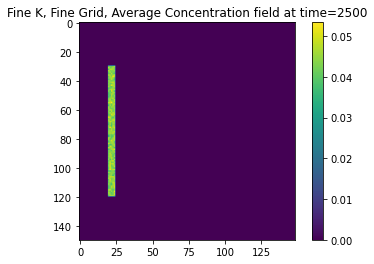

In [15]:
plt.imshow(np.mean(concs_fine[:,:-1],axis=2))
plt.colorbar()
plt.title('Fine K, Fine Grid, Average Concentration field at time=2500')
plt.show()